In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

ds = 0.001
lam_m1 = 59.995077600387965
old_sol_m1 = fsolve(eqns, x0=np.array([0.00349072, 0.94273727, 0.05377201]), args=(lam_m1,))
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0,))
print(old_sol_m1)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(5000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = abs(ds)
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol))
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.00103582 0.98261156 0.01635262]
[0.00103582 0.98261156 0.01635262]
206.77857848812454: [0.00103583 0.98261138 0.01635279]


[0.29363331 0.0945694  0.61179729]
[0.29377164 0.09454514 0.61168322]
0: 1.0008271606773327: [0.29374778 0.09454931 0.6117029 ]
1: 1.00065810810387: [0.2937244  0.09455341 0.61172218]
2: 1.0004890796934376: [0.29370102 0.09455751 0.61174146]
3: 1.000320057547211: [0.29367764 0.09456161 0.61176074]
4: 1.000151058496755: [0.29365427 0.09456571 0.61178002]
5: 0.9999821132858036: [0.29363089 0.09456982 0.6117993 ]
6: 0.9998132494500517: [0.29360751 0.09457392 0.61181857]
7: 0.9996442298766127: [0.29358413 0.09457802 0.61183785]
8: 0.9994753176157543: [0.29356075 0.09458212 0.61185713]
9: 0.9993064236359275: [0.29353737 0.09458622 0.6118764 ]
10: 0.9991375424611458: [0.293514   0.09459032 0.61189568]
11: 0.9989686898093262: [0.29349062 0.09459443 0.61191495]
12: 0.9987998648589655: [0.29346724 0.09459853 0.61193423]
13: 0.9986310485925312: [0.29344387 0.09460263 0.6119535 ]
14: 0.9984622495836994: [0.29342049 0.09460673 0.61197277]
15: 0.9982934934569839: [0.29339711 0.09461084 0.61199205]


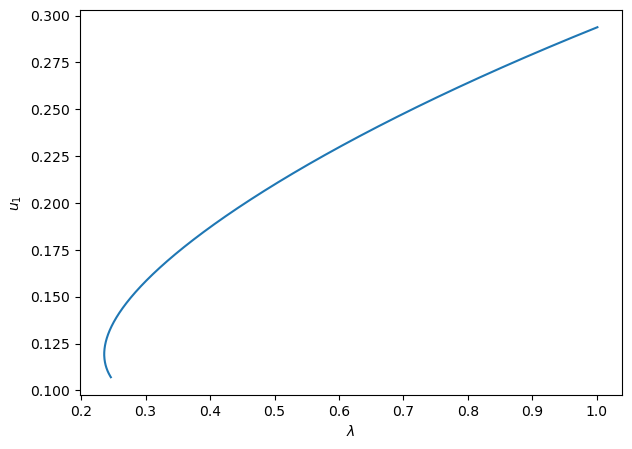

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.29353219, 0.09458548, 0.61188003]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(6846):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 10
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol1 = u1_sol
l_sol1 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.05846766 0.29134468 0.65018767]
[0.05846625 0.29135741 0.65017634]
0: 1.0000865966810175: [0.05846601 0.29135485 0.65017913]
1: 1.0000615625300193: [0.05846648 0.29135158 0.65018191]
2: 1.0000366466418424: [0.05846695 0.29134833 0.6501847 ]
3: 1.0000117274382876: [0.05846742 0.29134507 0.65018748]
4: 0.9999868118113777: [0.05846789 0.29134182 0.65019027]
5: 0.9999618939765751: [0.05846836 0.29133857 0.65019305]
6: 0.9999369773344836: [0.05846883 0.29133531 0.65019584]
7: 0.9999120615610603: [0.0584693  0.29133206 0.65019862]
8: 0.9998871493128771: [0.05846977 0.2913288  0.65020141]
9: 0.999862232246469: [0.05847023 0.29132555 0.65020419]
10: 0.999837318456592: [0.0584707  0.2913223  0.65020698]
11: 0.99981240366373: [0.05847117 0.29131904 0.65020976]
12: 0.9997874918451966: [0.05847164 0.29131579 0.65021255]
13: 0.9997625797192633: [0.05847211 0.29131253 0.65021533]
14: 0.9997376680689233: [0.05847258 0.29130928 0.65021812]
15: 0.9997127570739287: [0.05847305 0.29130603 0.6502209 ]


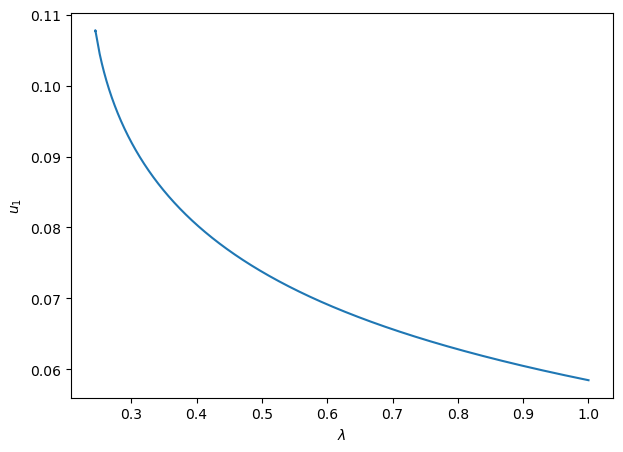

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.0001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.10703618, 0.159142, 0.73382182]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(38000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol2 = u1_sol
l_sol2 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

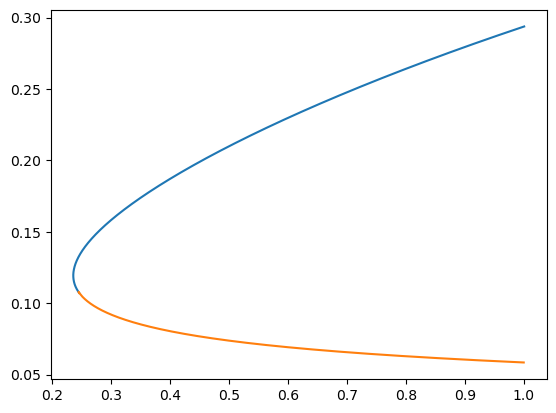

In [6]:
plt.plot(l_sol1, u1_sol1)
plt.plot(l_sol2, u1_sol2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.0001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.2, 0.3, 0.4]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(38000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.29363423 0.09456864 0.61179713]
[0.29364713 0.09456698 0.61178588]
0: 1.0000914348961865: [0.29364686 0.0945653  0.61178782]
1: 1.0000744281182368: [0.29364451 0.09456571 0.61178975]
2: 1.000057488441228: [0.29364217 0.09456612 0.61179169]
3: 1.0000405463618474: [0.29363983 0.09456653 0.61179362]
4: 1.0000236050253128: [0.29363748 0.09456695 0.61179555]
5: 1.0000066649532326: [0.29363514 0.09456736 0.61179748]
6: 0.9999897234150087: [0.29363279 0.09456777 0.61179942]
7: 0.9999727837877912: [0.29363045 0.09456818 0.61180135]
8: 0.999955842228134: [0.29362811 0.09456859 0.61180328]
9: 0.9999389028433681: [0.29362576 0.094569   0.61180522]
10: 0.9999219628479543: [0.29362342 0.09456941 0.61180715]
11: 0.9999050227357718: [0.29362107 0.09456982 0.61180908]
12: 0.9998880882626612: [0.29361873 0.09457023 0.61181101]
13: 0.9998711452222531: [0.29361639 0.09457065 0.61181295]
14: 0.9998542055851078: [0.29361404 0.09457106 0.61181488]
15: 0.9998372658020168: [0.2936117  0.09457147 0.61181681